# Recogntion Model Training

As a base for this notebook, [Yassine Ghouzam's tutorial](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) was taken  
**NOTE:** make sure you train it with GPU or otherwise it will take a while. If you don't have proper GPU locally, use free [Kaggle Kernel](https://www.kaggle.com/kernels)

# 1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline

# Set the random seed
random_seed = 2
num_classes = 52
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

np.random.seed(random_seed)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 2. Data preparation

In [2]:
train = pd.read_csv("./data/emnist/processed_balanced_train.csv")
test = pd.read_csv("./data/emnist/processed_balanced_test.csv")

In [3]:
Y_train = train["label"]
Y_test = test["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"], axis = 1) 
X_test = test.drop(labels = ["label"], axis = 1)

In [4]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,...,0,0])
Y_train = to_categorical(Y_train, num_classes = num_classes)
Y_test = to_categorical(Y_test, num_classes = num_classes)

In [5]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

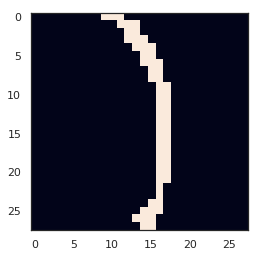

In [6]:
# Some examples
g = plt.imshow(X_train[10][:,:,0])

# 3. CNN
## 3.1 Define the model

In [7]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 3.2 Set the optimizer and annealer

In [8]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## 3.3 Data augmentation 

In [9]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [10]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 29s - loss: 1.0785 - acc: 0.6797 - val_loss: 0.3820 - val_acc: 0.8692
Epoch 2/10
 - 26s - loss: 0.5454 - acc: 0.8217 - val_loss: 0.3597 - val_acc: 0.8736
Epoch 3/10
 - 26s - loss: 0.4883 - acc: 0.8383 - val_loss: 0.3418 - val_acc: 0.8804
Epoch 4/10
 - 26s - loss: 0.4729 - acc: 0.8458 - val_loss: 0.3371 - val_acc: 0.8839
Epoch 5/10
 - 25s - loss: 0.4723 - acc: 0.8485 - val_loss: 0.3375 - val_acc: 0.8839
Epoch 6/10
 - 25s - loss: 0.4723 - acc: 0.8483 - val_loss: 0.3682 - val_acc: 0.8772
Epoch 7/10
 - 27s - loss: 0.4791 - acc: 0.8488 - val_loss: 0.3494 - val_acc: 0.8797

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/10
 - 25s - loss: 0.4396 - acc: 0.8575 - val_loss: 0.3333 - val_acc: 0.8878
Epoch 9/10
 - 25s - loss: 0.4388 - acc: 0.8588 - val_loss: 0.3428 - val_acc: 0.8852
Epoch 10/10
 - 27s - loss: 0.4422 - acc: 0.8582 - val_loss: 0.3469 - val_acc: 0.8829


# 4. Evaluate the model
## 4.1 Training and validation curves

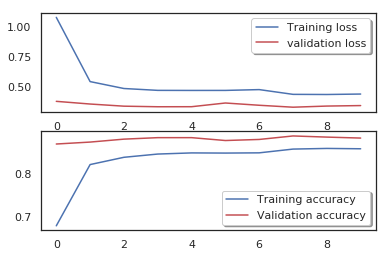

In [11]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

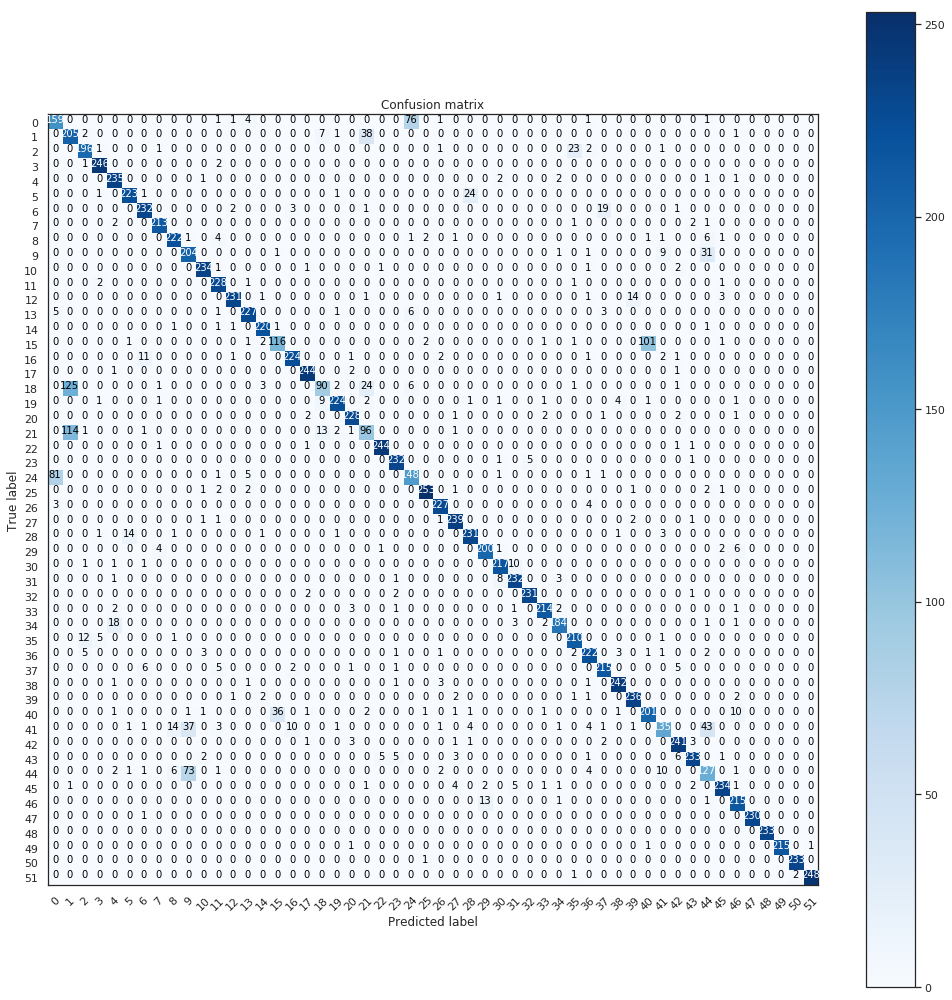

In [12]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix

figure(figsize=(14, 14))
plot_confusion_matrix(confusion_mtx, classes = range(num_classes)) 

## 4.3 Most common error

<Figure size 1008x1008 with 0 Axes>

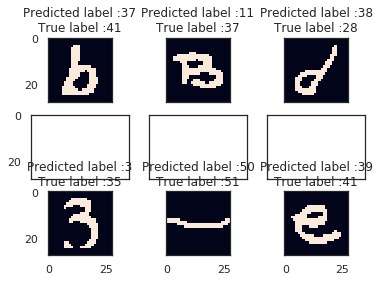

In [13]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows + 1,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row*2,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row*2,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
figure(figsize=(14, 14))

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Accurasy on train set

In [14]:
# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

Y_test = np.argmax(Y_test,axis = 1) 
conf_mat = confusion_matrix(results, Y_test)
acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
print('Overall accuracy: {} %'.format(acc*100))

Overall accuracy: 88.58653846153847 %


## Save the model

In [15]:
model.save('alphanum_model_binary_ex_88.h5')